In [1]:
!unzip bluebook-for-bulldozers.zip

Archive:  bluebook-for-bulldozers.zip
   creating: bluebook-for-bulldozers/
  inflating: __MACOSX/._bluebook-for-bulldozers  
  inflating: bluebook-for-bulldozers/random_forest_benchmark_test.csv  
  inflating: __MACOSX/bluebook-for-bulldozers/._random_forest_benchmark_test.csv  
  inflating: bluebook-for-bulldozers/Valid.csv  
  inflating: __MACOSX/bluebook-for-bulldozers/._Valid.csv  
  inflating: bluebook-for-bulldozers/median_benchmark.csv  
  inflating: __MACOSX/bluebook-for-bulldozers/._median_benchmark.csv  
  inflating: bluebook-for-bulldozers/Valid.zip  
  inflating: __MACOSX/bluebook-for-bulldozers/._Valid.zip  
  inflating: bluebook-for-bulldozers/TrainAndValid.7z  
  inflating: __MACOSX/bluebook-for-bulldozers/._TrainAndValid.7z  
  inflating: bluebook-for-bulldozers/Test.csv  
  inflating: __MACOSX/bluebook-for-bulldozers/._Test.csv  
  inflating: bluebook-for-bulldozers/Train.7z  
  inflating: __MACOSX/bluebook-for-bulldozers/._Train.7z  
  inflating: bluebook-for-bulldoz

In [2]:
!ls

bluebook-for-bulldozers      bulldozer-price-prediction-project.ipynb  __MACOSX
bluebook-for-bulldozers.zip  env


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [4]:
import seaborn as sns


# Predicting the sale price of bulldozers using machine learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem definition

> How well can we predict the future sale price of a bulldozer, given it's characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the kaggle bluebook for bulldozers competition:

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 you make predictions on this set throuhout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set dertermines your final rank for the competition.


## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check:
https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

**Note**: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning modek which minimizes RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [8]:
# Import training and validation sets
df = pd.read_csv("bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [9]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

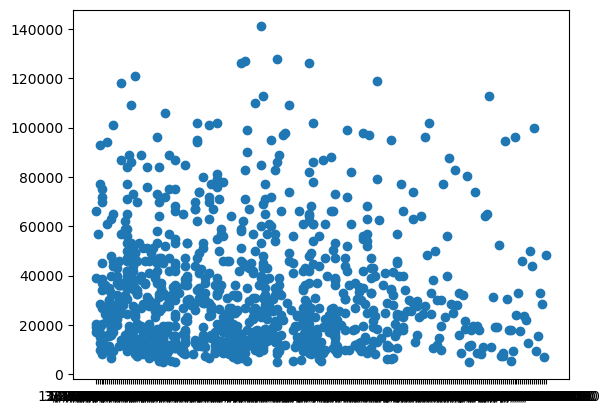

In [12]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

<Axes: ylabel='Frequency'>

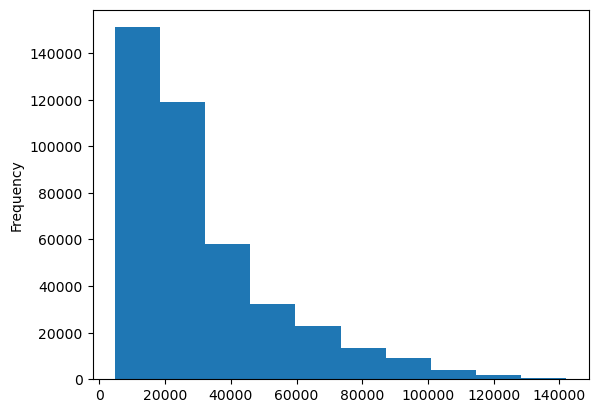

In [13]:
df.SalePrice.plot.hist()

### Parsing dates

When we work with time series data, we want to enrich the time and date component as much as possible.

We can do that by telling pandas which of our column has dates in it using the `parse_dates` parameter.

In [15]:
# Import data again but this time with parse dates
df = pd.read_csv("bluebook-for-bulldozers/TrainAndValid.csv", 
                 low_memory=False, 
                 parse_dates=["saledate"])

In [16]:
df.saledate.dtype

dtype('<M8[ns]')

In [17]:
df.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

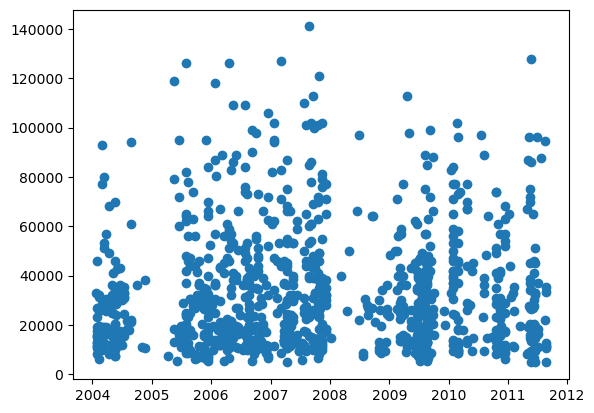

In [18]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [19]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [21]:
# Sort dataframe in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)

In [22]:
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of original dataframe

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [23]:
# Make a copy
df_tmp = df.copy()


In [24]:
df_tmp.saledate.head()


205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Add datetime parameters for `saledate` column

In [26]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [28]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [29]:
df_tmp.drop("saledate", axis=1, inplace=True)

In [30]:
# Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [32]:
# Let's build a machine learning model

from sklearn.ensemble import RandomForestRegressor

In [35]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

ValueError: could not convert string to float: 'Low'

In [36]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert string to categories
One way we can turn all of our data into numbers is by converting them into pandas categories.

In [38]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [39]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [42]:
# If you're wondering what df.items() does, here's an example
random_dict = {
    "key1": "hello",
    "key2": "world!"
}

for key, value in random_dict.items():
    print(f"This is a key: {key}", f"this is a value: {value}")

This is a key: key1 this is a value: hello
This is a key: key2 this is a value: world!


In [43]:
# This will turn all of the string value into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [44]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [45]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

Thanks to pandas categories we now have a way to access all of our data in the form of numbers.

But we still have a bunch of missing data...

### Save preprocessed data

In [47]:
# Export current tmp dataframe
df_tmp.to_csv("bluebook-for-bulldozers/train_tmp.csv", index=False)

In [50]:
# Import preprocessed data
df_tp = pd.read_csv("bluebook-for-bulldozers/train_tmp.csv", low_memory=False)
df_tp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


## Fill missing values

### Fill numerical missing values first

In [51]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleDay
saleMonth
saleDayOfWeek
saleDayOfYear


In [52]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [53]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [56]:
df_tmp.tail(20)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleDay,saleMonth,saleDayOfWeek,saleDayOfYear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
406079,6258623,22000.0,1877704,3192,149,99.0,2001,0.0,NaN,590SUPER M,...,NaN,NaN,NaN,2012,28,4,5,119,False,True
409783,6286233,24000.0,1932403,4605,149,99.0,2005,0.0,NaN,310G,...,NaN,NaN,NaN,2012,28,4,5,119,False,True
411522,6310488,7000.0,1911585,9550,149,99.0,1000,0.0,NaN,753,...,NaN,NaN,NaN,2012,28,4,5,119,False,True
412218,6319596,20500.0,1887135,18110,149,99.0,2005,0.0,NaN,BL60,...,NaN,NaN,NaN,2012,28,4,5,119,False,True
411527,6310504,6000.0,1921721,9550,149,99.0,1996,0.0,NaN,753,...,NaN,NaN,NaN,2012,28,4,5,119,False,True
406092,6258697,31000.0,1907659,3239,149,99.0,2001,0.0,NaN,850H,...,None or Unspecified,NaN,NaN,2012,28,4,5,119,False,True
409780,6286207,25000.0,1848914,4605,149,99.0,2004,0.0,NaN,310G,...,NaN,NaN,NaN,2012,28,4,5,119,False,True
406167,6259091,26000.0,1789854,3180,149,99.0,2005,0.0,NaN,580SUPER M,...,NaN,NaN,NaN,2012,28,4,5,119,False,True
411334,6306548,36000.0,1878032,28919,149,99.0,2004,0.0,NaN,WA2505L,...,NaN,Standard,Conventional,2012,28,4,5,119,False,True
412164,6318085,5500.0,1873607,10402,149,99.0,2001,0.0,NaN,1300,...,NaN,NaN,NaN,2012,28,4,5,119,False,True


In [57]:
df_tmp["MachineHoursCurrentMeter_is_missing"].value_counts()

True     265194
False    147504
Name: MachineHoursCurrentMeter_is_missing, dtype: int64

In [58]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [59]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

### Filling and turning categorical variables into numbers

In [60]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [61]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

In [62]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label + "_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes + 1

In [63]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [67]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all of data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [68]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [69]:
%%time
# Instantiate model 
model = RandomForestRegressor(n_jobs=-1, random_state=42)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

CPU times: user 22min 59s, sys: 7.84 s, total: 23min 7s
Wall time: 6min 52s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [71]:
# score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

0.9875440066186206

**Question:** Why doesn't the above metric hold water?

### Splitting data into train/validation sets

In [73]:
df_tmp.saleYear

205615    1989
274835    1989
141296    1989
212552    1989
62755     1989
          ... 
410879    2012
412476    2012
411927    2012
407124    2012
409203    2012
Name: saleYear, Length: 412698, dtype: int64

In [74]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [75]:
# Split data into training and validation.
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

In [76]:
len(df_val)

11573

In [77]:
len(df_train)

401125

In [78]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice

In [79]:
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

In [82]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function

In [84]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculate root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

In [86]:
# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {
        "Training MAE": mean_absolute_error(y_train, train_preds),
        "Valid MAE": mean_absolute_error(y_valid, val_preds),
        "Training RMSLE": rmsle(y_train, train_preds),
        "Valid RMSLE": rmsle(y_valid, val_preds),
        "Training R^2": r2_score(y_train, train_preds),
        "Valid R^2": r2_score(y_valid, val_preds)
    }
    return scores

## Testing our model on a subset (to tune the hyperparameters)

In [87]:
# This takes far too long... for experimenting

#%%time
#model = RandomForestRegressor(n_jobs=-1, random_state=42)


In [88]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)
model.fit(X_train, y_train)

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [89]:
show_scores(model)

{'Training MAE': 5562.079819856652,
 'Valid MAE': 7178.695028082606,
 'Training RMSLE': 0.2577376357095064,
 'Valid RMSLE': 0.2933375745468615,
 'Training R^2': 0.8605891310325422,
 'Valid R^2': 0.8315394436192207}

### Hyperparameter tuning with RandomizedSearchCV

In [93]:
%%time

from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.5, 1, "sqrt"],
    "max_samples": [10000]
}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                              param_distributions=rf_grid, n_iter=5, cv=5, verbose=True)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 20.9 s, sys: 4.64 s, total: 25.6 s
Wall time: 46.8 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [94]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 8,
 'min_samples_leaf': 19,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': 10}

In [95]:
# Evaluate the randomized search model
show_scores(rs_model)

{'Training MAE': 9376.42171681554,
 'Valid MAE': 10922.200677764758,
 'Training RMSLE': 0.4098347714086438,
 'Valid RMSLE': 0.43175298085279284,
 'Training R^2': 0.6537050029299073,
 'Valid R^2': 0.6584470007723715}

### Train a model with the best hyperparameters
**Note:** These were found after 100 iterations of `RandomizedSearchCV`

In [96]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5, 
                                    n_jobs=-1, 
                                    max_samples=None)

ideal_model.fit(X_train, y_train)

CPU times: user 4min 9s, sys: 3.24 s, total: 4min 12s
Wall time: 1min 19s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [97]:
show_scores(ideal_model)

{'Training MAE': 2951.849802978353,
 'Valid MAE': 5939.21048052936,
 'Training RMSLE': 0.1446341900450241,
 'Valid RMSLE': 0.2457630500901765,
 'Training R^2': 0.9589239371756003,
 'Valid R^2': 0.8823840238447279}

In [98]:
# scores on rs_model (only trained on ~10k examples)
show_scores(rs_model)

{'Training MAE': 9376.42171681554,
 'Valid MAE': 10922.200677764758,
 'Training RMSLE': 0.4098347714086438,
 'Valid RMSLE': 0.4317529808527929,
 'Training R^2': 0.6537050029299073,
 'Valid R^2': 0.6584470007723715}

## Make predictions on test data

In [109]:
# Import the test data
test_data = pd.read_csv("bluebook-for-bulldozers/Test.csv", parse_dates=["saledate"])
test_data.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [102]:
test_data.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [104]:
# Make predictions on the test dataset
test_preds = ideal_model.predict(test_data)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...


In [105]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [110]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleDay"] = df.saledate.dt.day
    df["saleMonth"] = df.saledate.dt.month
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    df["auctioneerID_is_missing"] = False
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label + "_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turned categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label + "_is_missing"] = pd.isnull(content)
            # We add + 1 to categories code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes + 1
    
    
    return df

In [111]:
test_tmp = preprocess_data(test_data)

In [112]:
test_tmp.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [113]:
# Make predictions on the test dataset
test_preds = ideal_model.predict(test_data)

In [114]:
test_preds

array([18156.0697212 , 16719.88923434, 46046.98908669, ...,
       12242.19181734, 18382.16965241, 25631.56247865])

In [116]:
# Format predictions into the same format kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = test_tmp["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,18156.069721
1,1227844,16719.889234
2,1227847,46046.989087
3,1227848,68191.491003
4,1227863,61858.002262
...,...,...
12452,6643171,37328.543864
12453,6643173,11089.282232
12454,6643184,12242.191817
12455,6643186,18382.169652


In [120]:
df_preds.to_csv("test_preds.csv", index=False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable**

In [124]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.45055994e-02, 1.79130802e-02, 4.15134010e-02, 1.63179493e-03,
       3.37473875e-03, 2.00609860e-01, 3.18974153e-03, 1.08391186e-03,
       4.28232698e-02, 4.74289582e-02, 6.81375074e-02, 4.83514056e-03,
       1.80568556e-02, 1.44005576e-01, 4.18362098e-02, 5.94144977e-03,
       5.31256808e-03, 4.40655596e-03, 3.80952437e-03, 6.99381776e-02,
       5.09544623e-04, 5.57537789e-05, 8.23760363e-04, 1.99030529e-04,
       1.25447910e-03, 2.26243144e-05, 7.09750452e-04, 1.07287828e-02,
       5.94150062e-04, 2.15817102e-03, 2.68068579e-03, 3.32489950e-03,
       3.36057053e-03, 2.22964120e-03, 2.13967971e-04, 7.90196477e-03,
       8.94516117e-04, 1.21433556e-02, 1.32389706e-03, 1.76402966e-03,
       6.85188209e-04, 7.39974125e-04, 2.96892186e-03, 5.49203830e-04,
       4.90325496e-04, 3.41977336e-04, 5.52850962e-04, 2.66164168e-03,
       9.40750283e-04, 2.33688588e-04, 1.54063392e-04, 7.22022432e-02,
       5.67656245e-03, 3.83883272e-03, 2.87503086e-03, 9.86972598e-03,
      

In [125]:
X_train.columns


Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
       'Thumb_is_missing', 'Pattern_Changer_is_missing',
       'Grouser_Type_is_missing', 'Backhoe_Mounting_is_missing',
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing'],
      dtype='object', length=102)

In [135]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns, "feature_importances": importances}).sort_values("feature_importances", ascending=False)
         ).reset_index(drop=True)
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

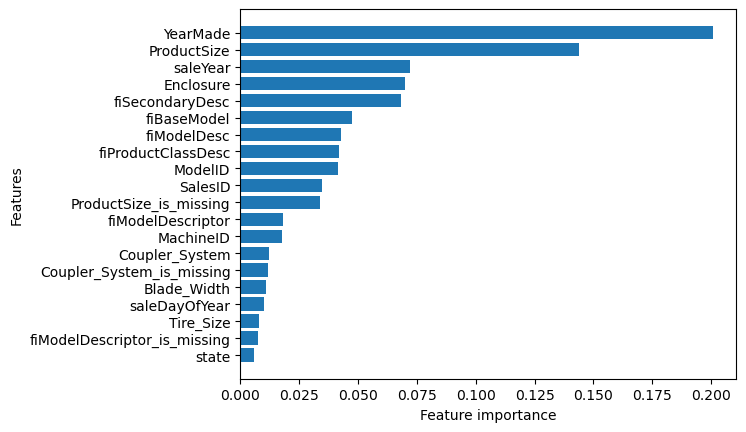

In [136]:
plot_features(X_train.columns, ideal_model.feature_importances_)